In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Read Data**

In [ ]:
import pandas as pd

In [ ]:
news_train=pd.read_excel('/content/drive/MyDrive/News_train.xlsx')

In [ ]:
news_train.shape

(5000, 2)

# **Preprocessing**

### **re**

In [ ]:
!pip install pyarabic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 1.1 MB/s eta 0:00:00


In [ ]:
import pyarabic

In [ ]:
import re
import unicodedata
from pyarabic.araby import tokenize

def normalize_arabic(text):
    # Normalize Arabic text
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn') # remove diacritics
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub('/', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub('_', ' ', text)
    text = re.sub(' و ', ' ', text)
    text = re.sub("'", ' ', text)
    text = re.sub("``", ' ', text)
    text = re.sub('"', ' ', text)
    text = re.sub('%', ' ', text)
    text = re.sub('»', ' ', text)
    text = re.sub('«', ' ', text)
    text = re.sub(r'\bال(\w+)\b', r'\1', text)
    text = re.sub(r'\bلل(\w+)\b', r'\1', text)
    text = re.sub(r'\bبال(\w+)\b', r'\1', text)
    text = re.sub(r'[A-Za-z0-9]', r'', text)#remove english characters
    text = re.sub(r'[0-9]', r'', text)#remove numbers
    text = re.sub(r'[^\w\s]', r'', text)#remove punctuation

    words = tokenize(text)

    normalized_text = ' '.join(words)

    return normalized_text

In [ ]:
news_train['News'] = news_train['News'].apply(normalize_arabic)

In [ ]:
news_train['News']

0       اشتباك حريري عون اتهامات لباسيل تمسك ثلث معطل ...
1                               عون حريري اصبح غريب اطوار
2       وزير خارجيه امريكي ندرس سحب كامل قواتنا من افغ...
3       افغانستان استعدادات حثيثه لاجتماع تركيا وكابل ...
4                   اندبندنت مفاوضات سريه كادت تنقذ قذافي
                              ...                        
4995                اوروبا تبدا احصاء خساير فيضانات مدمره
4996    قتل متظاهر رصاص خلال احتجاجات علي شح مياه في م...
4997    وسايل اعلام ايرانيه تتحدث عن اندلاع احتجاجات ف...
4998           مفاوضات افغانيه تتواصل في عاصمه قطريه دوحه
4999    تعليق مفاوضات افغانيه في دوحه موقتا لمزيد من م...
Name: News, Length: 5000, dtype: object

In [ ]:
news_train.shape

(5000, 2)

### **nltk**

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
from pyarabic.araby import tokenize
from nltk.corpus import stopwords
from nltk.stem import ISRIStemmer

stemmer = ISRIStemmer()

def preprocess_text(text):
    # Tokenization for Arabic text using PyArabic's tokenize function
    tokens = tokenize(text)

    # Get Arabic stop words from NLTK
    stop_words_arabic = set(stopwords.words('arabic'))

    # Remove stop words
    arabic_tokens = [token for token in tokens if token not in stop_words_arabic]

    # Stemming Arabic text
    arabic_tokens = [stemmer.stem(token) for token in arabic_tokens]

    # Join tokens back into text
    processed_text = ' '.join(arabic_tokens)

    return processed_text

In [ ]:
preprocessed_documents_news_train = [preprocess_text(doc) for doc in news_train['News']]

In [ ]:
len(preprocessed_documents_news_train)

5000

# **Splitting the data into training and validation**

In [ ]:
news_train['processed_text'] = preprocessed_documents_news_train

In [ ]:
news_train['processed_text']

0                 شبك حرر عون تهم اسل تمس ثلث عطل بقء حكم
1                                    عون حرر اصبح غرب طور
2                     وزر خرج امر درس سحب كمل قوت غنس حلل
3       غنس عدد حثث جمع ترك كبل تهم طلب ركز علي حرب بد...
4                            اندبندنت فاض سره كدت نقذ قذف
                              ...                        
4995                             ورب تبد حصء خسير فيض دمر
4996      قتل ظاهر رصص خلل حجج علي شح ياه طقه جنب غرب اير
4997                          سيل علم يرن حدث دلع حجج شرع
4998                              فاض فغن وصل عصم قطر دوح
4999                          علق فاض فغن دوح وقت زيد شار
Name: processed_text, Length: 5000, dtype: object

In [ ]:
news_train.columns

Index(['Type', 'News', 'processed_text'], dtype='object')

In [ ]:
y=news_train['Type']
X=news_train.drop(columns=['Type', 'News'], axis=1)

In [ ]:
y

0       politics
1       politics
2       politics
3       politics
4       politics
          ...   
4995    politics
4996    politics
4997    politics
4998    politics
4999    politics
Name: Type, Length: 5000, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
len(X_train)

4250

# **Word Embedding(Bert)**

In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
from nltk.tokenize import word_tokenize
import torch


In [ ]:
from transformers import AutoTokenizer, AutoModel
# Specify the pre-trained model name
model_name = "aubmindlab/bert-base-arabert"
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/717k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
#X_test['processed_text']

In [ ]:
#preprocessed_documents

In [ ]:
token_ids_list =[]
for sentence in X_train['processed_text']:
  tokens = tokenizer.tokenize(sentence)
  #print(tokens)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  #print(token_ids)
  token_ids_list.append(token_ids)
#print(token_ids_list)
#len(token_ids_list)

# Find the maximum length of tokenized documents
max_length = max(len(token_ids) for token_ids in token_ids_list)

# Pad the sequences
padded_token_ids_list = [token_ids + [tokenizer.pad_token_id] * (max_length - len(token_ids)) for token_ids in token_ids_list]
#print(padded_token_ids_list)
#print(max_length)
#len(padded_token_ids_list[1])

token_ids_tensor = torch.tensor(padded_token_ids_list)
#len(token_ids_tensor)

# Pass token IDs through the model to get embeddings
with torch.no_grad():
    outputs = model(token_ids_tensor)
# Extract the embeddings
embeddings_bert_X_train = outputs.last_hidden_state
mean_embeddings_bert_X_train = torch.mean(embeddings_bert_X_train, dim=1)

# Print the shape of the embeddings
print(mean_embeddings_bert_X_train.shape)  # Output: torch.Size([1, num_tokens, hidden_size])
print(mean_embeddings_bert_X_train)
#i need to do the mean for each sentence (tokens) from lab 6

torch.Size([4250, 768])
tensor([[-0.4100,  1.1810,  0.3797,  ...,  0.3575,  0.2373,  0.5019],
        [-0.2210,  0.8721,  0.5181,  ...,  0.3745,  0.4606,  0.2593],
        [-0.1368,  1.1617,  0.5227,  ...,  0.3514,  0.1207,  0.7223],
        ...,
        [-0.1199,  0.6032,  0.3097,  ...,  0.1746,  0.3209,  0.5053],
        [-0.4525,  1.1990,  0.2001,  ...,  0.1550,  0.0713,  0.6168],
        [-0.3391,  1.0201,  0.6035,  ...,  0.3292,  0.3743, -0.2531]])


In [ ]:
token_ids_list =[]
for sentence in X_test['processed_text']:
  tokens = tokenizer.tokenize(sentence)
  #print(tokens)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  #print(token_ids)
  token_ids_list.append(token_ids)
#print(token_ids_list)
#len(token_ids_list)

# Find the maximum length of tokenized documents
max_length = max(len(token_ids) for token_ids in token_ids_list)

# Pad the sequences
padded_token_ids_list = [token_ids + [tokenizer.pad_token_id] * (max_length - len(token_ids)) for token_ids in token_ids_list]
#print(padded_token_ids_list)
#print(max_length)
#len(padded_token_ids_list[1])

token_ids_tensor = torch.tensor(padded_token_ids_list)
#len(token_ids_tensor)

# Pass token IDs through the model to get embeddings
with torch.no_grad():
    outputs = model(token_ids_tensor)
# Extract the embeddings
embeddings_bert_X_test = outputs.last_hidden_state


In [ ]:
mean_embeddings_bert_X_test = torch.mean(embeddings_bert_X_test, dim=1)

# Print the shape of the embeddings
print(mean_embeddings_bert_X_test.shape)  # Output: torch.Size([1, num_tokens, hidden_size])
print(mean_embeddings_bert_X_test)

torch.Size([750, 768])
tensor([[-0.1267,  0.7213,  0.5595,  ..., -0.2352,  0.4625,  0.2602],
        [-0.0027,  0.7472,  0.0851,  ..., -0.3475,  0.4353,  0.2644],
        [-0.1737,  1.0602,  0.5677,  ...,  0.3261,  0.3380,  0.2807],
        ...,
        [-0.3375,  0.4793,  0.6670,  ..., -0.3133,  0.0535,  0.2965],
        [-0.0937,  0.5414,  0.1172,  ..., -0.2183,  0.2837,  0.1610],
        [-0.1662,  0.9255,  0.3454,  ...,  0.4249,  0.3008,  0.4255]])


In [ ]:
# Save BERT embeddings
import numpy as np

# Convert torch tensors to numpy arrays
mean_embeddings_bert_X_train_np = mean_embeddings_bert_X_train.numpy()
mean_embeddings_bert_X_test_np = mean_embeddings_bert_X_test.numpy()

# Save the embeddings
np.save('X_train_bert_embeddings.npy', mean_embeddings_bert_X_train_np)
np.save('X_test_bert_embeddings.npy', mean_embeddings_bert_X_test_np)


# **Models**

# **Traditional Models**

## **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
embeddings_bert_X_train[0].shape

torch.Size([32, 768])

In [ ]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(mean_embeddings_bert_X_train, y_train)

y_pred = naive_bayes_classifier.predict(mean_embeddings_bert_X_test)

accuracy_NB = accuracy_score(y_test, y_pred)
f1_NB = f1_score(y_test, y_pred,average='macro')
print('accuracy',accuracy_NB)
print('f1 score',f1_NB)

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy 0.48
f1 score 0.3895822147533964
Classification Report:
              precision    recall  f1-score   support

    economic       0.24      0.60      0.34       134
    politics       0.80      0.45      0.57       488
       sport       0.48      0.49      0.49       120
        tech       0.11      0.25      0.15         8

    accuracy                           0.48       750
   macro avg       0.41      0.45      0.39       750
weighted avg       0.64      0.48      0.51       750



## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
embeddings_bert_X_train[0].shape

torch.Size([32, 768])

In [ ]:
Decision_Tree_classifier = DecisionTreeClassifier()
Decision_Tree_classifier.fit(mean_embeddings_bert_X_train, y_train)

y_pred = Decision_Tree_classifier.predict(mean_embeddings_bert_X_test)

accuracy_DT = accuracy_score(y_test, y_pred)
f1_DT = f1_score(y_test, y_pred,average='macro')
print('accuracy',accuracy_DT)
print('f1 score',f1_DT)

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy 0.576
f1 score 0.38004941313308904
Classification Report:
              precision    recall  f1-score   support

    economic       0.27      0.28      0.27       134
    politics       0.75      0.68      0.71       488
       sport       0.42      0.53      0.47       120
        tech       0.04      0.12      0.06         8

    accuracy                           0.58       750
   macro avg       0.37      0.40      0.38       750
weighted avg       0.61      0.58      0.59       750



# **Neural Language Models**

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## **RNN (Recurrent Neural Networks)**

In [ ]:
from keras.layers import SimpleRNN

In [ ]:
from sklearn.metrics import accuracy_score

# Convert the BERT embeddings from PyTorch tensors to NumPy arrays
mean_embeddings_bert_X_train_array = mean_embeddings_bert_X_train.numpy()
mean_embeddings_bert_X_test_array = mean_embeddings_bert_X_test.numpy()

# Define label mapping
label_mapping = {'economic': 0, 'politics': 1, 'sport': 2, 'tech': 3}

num_class = len(set(y_train))

# Encode the categorical labels into numerical format using the mapping
y_train_encoded_manual = np.array([label_mapping[label] for label in y_train])
y_test_encoded_manual = np.array([label_mapping[label] for label in y_test])

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded_manual, num_classes=num_class)
y_test_one_hot = to_categorical(y_test_encoded_manual, num_classes=num_class)

# Reshape the input data to add a timestep dimension
X_train_reshaped = mean_embeddings_bert_X_train_array.reshape(-1, 1, mean_embeddings_bert_X_train_array.shape[1])
X_test_reshaped = mean_embeddings_bert_X_test_array.reshape(-1, 1, mean_embeddings_bert_X_test_array.shape[1])

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(1, mean_embeddings_bert_X_train_array.shape[1])))
model.add(Dense(units=num_class, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=32)

# Predict on the test set
y_pred_probabilities = model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred_encoded_manual = np.argmax(y_pred_probabilities, axis=1)

print("Classification Report:")
print(classification_report(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual))

accuracy_RNN = accuracy_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual)
f1_RNN = f1_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual,average='macro')
print('accuracy',accuracy_RNN)
print('f1 score',f1_RNN)



Epoch 1/10
133/133 [==============================] - 2s 4ms/step - loss: 0.8475 - accuracy: 0.6736
Epoch 2/10
133/133 [==============================] - 1s 4ms/step - loss: 0.6687 - accuracy: 0.7539
Epoch 3/10
133/133 [==============================] - 1s 5ms/step - loss: 0.5953 - accuracy: 0.7819
Epoch 4/10
133/133 [==============================] - 1s 4ms/step - loss: 0.5523 - accuracy: 0.7984
Epoch 5/10
133/133 [==============================] - 0s 3ms/step - loss: 0.5285 - accuracy: 0.8024
Epoch 6/10
133/133 [==============================] - 0s 3ms/step - loss: 0.5256 - accuracy: 0.8002
Epoch 7/10
133/133 [==============================] - 0s 3ms/step - loss: 0.5006 - accuracy: 0.8113
Epoch 8/10
133/133 [==============================] - 0s 3ms/step - loss: 0.4839 - accuracy: 0.8167
Epoch 9/10
133/133 [==============================] - 0s 3ms/step - loss: 0.4864 - accuracy: 0.8136
Epoch 10/10
24/24 [==============================] - 0s 2ms/step
Classification Report:
            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **LSTM (Long Short Term Memory)**

In [ ]:
from keras.layers import LSTM

In [ ]:
from sklearn.metrics import accuracy_score

# Convert the BERT embeddings from PyTorch tensors to NumPy arrays
mean_embeddings_bert_X_train_array = mean_embeddings_bert_X_train.numpy()
mean_embeddings_bert_X_test_array = mean_embeddings_bert_X_test.numpy()

# Define label mapping
label_mapping = {'economic': 0, 'politics': 1, 'sport': 2, 'tech': 3}

num_class = len(set(y_train))

# Encode the categorical labels into numerical format using the mapping
y_train_encoded_manual = np.array([label_mapping[label] for label in y_train])
y_test_encoded_manual = np.array([label_mapping[label] for label in y_test])

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded_manual, num_classes=num_class)
y_test_one_hot = to_categorical(y_test_encoded_manual, num_classes=num_class)

# Reshape the input data to add a timestep dimension
X_train_reshaped = mean_embeddings_bert_X_train_array.reshape(-1, 1, mean_embeddings_bert_X_train_array.shape[1])
X_test_reshaped = mean_embeddings_bert_X_test_array.reshape(-1, 1, mean_embeddings_bert_X_test_array.shape[1])

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(1, mean_embeddings_bert_X_train_array.shape[1])))
model.add(Dense(units=num_class, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=32)

# Predict on the test set
y_pred_probabilities = model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred_encoded_manual = np.argmax(y_pred_probabilities, axis=1)


print("Classification Report:")
print(classification_report(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual))

accuracy_LSTM = accuracy_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual)
f1_LSTM = f1_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual,average='macro')
print('accuracy',accuracy_LSTM)
print('f1 score',f1_LSTM)



Epoch 1/10
133/133 [==============================] - 3s 5ms/step - loss: 0.8462 - accuracy: 0.6706
Epoch 2/10
133/133 [==============================] - 1s 5ms/step - loss: 0.6372 - accuracy: 0.7645
Epoch 3/10
133/133 [==============================] - 1s 5ms/step - loss: 0.5798 - accuracy: 0.7913
Epoch 4/10
133/133 [==============================] - 1s 6ms/step - loss: 0.5475 - accuracy: 0.7998
Epoch 5/10
133/133 [==============================] - 1s 6ms/step - loss: 0.5255 - accuracy: 0.8082
Epoch 6/10
133/133 [==============================] - 1s 6ms/step - loss: 0.5322 - accuracy: 0.7991
Epoch 7/10
133/133 [==============================] - 1s 8ms/step - loss: 0.4942 - accuracy: 0.8127
Epoch 8/10
133/133 [==============================] - 1s 10ms/step - loss: 0.4905 - accuracy: 0.8136
Epoch 9/10
133/133 [==============================] - 1s 10ms/step - loss: 0.4867 - accuracy: 0.8205
Epoch 10/10
24/24 [==============================] - 1s 3ms/step
Classification Report:
          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **GRU (Gate Recurrent Unit)**

In [ ]:
from keras.layers import GRU

In [ ]:
from sklearn.metrics import accuracy_score

# Convert the BERT embeddings from PyTorch tensors to NumPy arrays
mean_embeddings_bert_X_train_array = mean_embeddings_bert_X_train.numpy()
mean_embeddings_bert_X_test_array = mean_embeddings_bert_X_test.numpy()

# Define label mapping
label_mapping = {'economic': 0, 'politics': 1, 'sport': 2, 'tech': 3}

num_class = len(set(y_train))

# Encode the categorical labels into numerical format using the mapping
y_train_encoded_manual = np.array([label_mapping[label] for label in y_train])
y_test_encoded_manual = np.array([label_mapping[label] for label in y_test])

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded_manual, num_classes=num_class)
y_test_one_hot = to_categorical(y_test_encoded_manual, num_classes=num_class)

# Reshape the input data to add a timestep dimension
X_train_reshaped = mean_embeddings_bert_X_train_array.reshape(-1, 1, mean_embeddings_bert_X_train_array.shape[1])
X_test_reshaped = mean_embeddings_bert_X_test_array.reshape(-1, 1, mean_embeddings_bert_X_test_array.shape[1])

# Define the GRU model
model = Sequential()
model.add(GRU(units=64, input_shape=(1, mean_embeddings_bert_X_train_array.shape[1])))
model.add(Dense(units=num_class, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=32)

# Predict on the test set
y_pred_probabilities = model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred_encoded_manual = np.argmax(y_pred_probabilities, axis=1)

print("Classification Report:")
print(classification_report(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual))

accuracy_GRU = accuracy_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual)
f1_GRU= f1_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual,average='macro')
print('accuracy',accuracy_GRU)
print('f1 score',f1_GRU)



Epoch 1/10
133/133 [==============================] - 3s 5ms/step - loss: 0.8305 - accuracy: 0.6769
Epoch 2/10
133/133 [==============================] - 1s 5ms/step - loss: 0.6317 - accuracy: 0.7652
Epoch 3/10
133/133 [==============================] - 1s 5ms/step - loss: 0.5768 - accuracy: 0.7866
Epoch 4/10
133/133 [==============================] - 1s 5ms/step - loss: 0.5481 - accuracy: 0.8014
Epoch 5/10
133/133 [==============================] - 1s 5ms/step - loss: 0.5216 - accuracy: 0.8066
Epoch 6/10
133/133 [==============================] - 1s 5ms/step - loss: 0.5079 - accuracy: 0.8038
Epoch 7/10
133/133 [==============================] - 1s 5ms/step - loss: 0.5056 - accuracy: 0.8080
Epoch 8/10
133/133 [==============================] - 1s 5ms/step - loss: 0.4770 - accuracy: 0.8214
Epoch 9/10
133/133 [==============================] - 1s 6ms/step - loss: 0.4791 - accuracy: 0.8228
Epoch 10/10
24/24 [==============================] - 0s 2ms/step
Classification Report:
            

# **Plot**

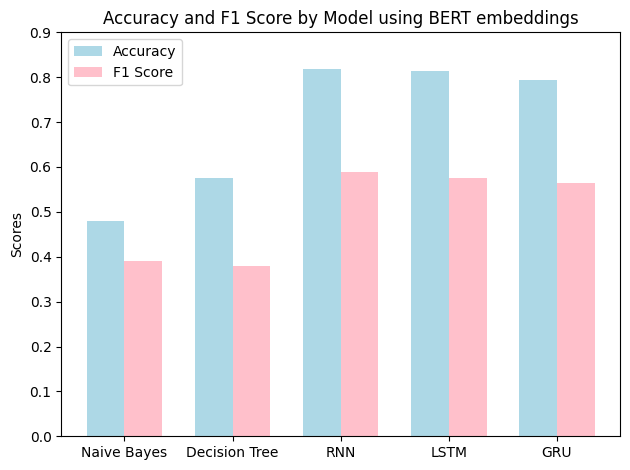

In [ ]:
import matplotlib.pyplot as plt
models = ['Naive Bayes', 'Decision Tree', 'RNN', 'LSTM', 'GRU']
accuracies = [accuracy_NB, accuracy_DT, accuracy_RNN, accuracy_LSTM, accuracy_GRU]
f1_scores = [f1_NB, f1_DT, f1_RNN, f1_LSTM, f1_GRU]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy',color='lightblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score',color='pink')

ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score by Model using BERT embeddings')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.set_ylim(0,0.9)
fig.tight_layout()
plt.show()